In [1]:
# beware mujoco 2.3.3 has a bug, time is not incremented in step function
!pip install mujoco==2.3.2
import mujoco
!source /home/geraldebmer/catkin_ws/devel/setup.bash
import arcpy

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
#@title Other imports and helper functions
import numpy as np
from typing import Callable, Optional, Union, List
import scipy.linalg

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:

[notice] A new release of pip is available: 23.0.1 -> 23.1.1
[notice] To update, run: python3 -m pip install --upgrade pip


In [3]:
xml_filepath = "./iiwa_robotiq_85.xml"
with open(xml_filepath, 'r') as f:
  xml = f.read()

In [4]:
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

""

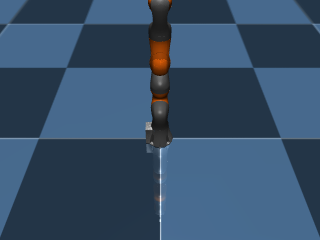

In [5]:
mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

key: 0


""

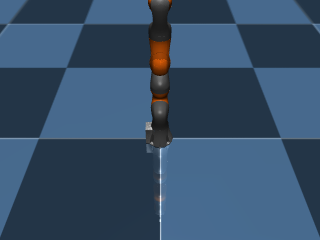

In [6]:
for key in range(model.nkey):
    print("key: " + str(key))
    mujoco.mj_resetDataKeyframe(model, data, key)
    mujoco.mj_forward(model, data)
    renderer.update_scene(data)
    media.show_image(renderer.render())

In [7]:
DURATION  = 3   # seconds
FRAMERATE = 60  # Hz

# Initialize to the standing-on-one-leg pose.
mujoco.mj_resetDataKeyframe(model, data, 0)

Ts = 0.001
sim_flag = True
ctr_param = arcpy.Iiwa.IiwaContrParam(sim_flag)
f_c_slow_norm = ctr_param.f_c_slow * (2*Ts)
robot_model = arcpy.Iiwa.RobotModel(f_c_slow_norm,Ts)

js_param = arcpy.Iiwa.JointCTParameter(ctr_param)
ts_param = arcpy.Iiwa.CartesianCTParameter(ctr_param)
f_c_fast_norm = ctr_param.f_c_fast * (2*Ts)
sp_param = arcpy.Iiwa.SingularPerturbationParameter(ctr_param.K_sp, ctr_param.D_sp, f_c_fast_norm)
B_fc = robot_model.get_B()
fc_param = arcpy.Iiwa.FrictionCompensationParameter(ctr_param.L_fc, B_fc, f_c_fast_norm)
gc_param = arcpy.Iiwa.GravityCompParameter(ctr_param.D_gc)

hanging = False
arc_contr = arcpy.Iiwa.LBRIiwa(robot_model,Ts, js_param, ts_param, sp_param, fc_param, gc_param, hanging)
arc_contr.set_singular_perturbation_state(False)
arc_contr.set_friction_compensation_state(False)

q0 = data.qpos[0:7]
joint_init_pos = np.ones((7,1))
T_traj = 2
arc_contr.start(data.time, q0, joint_init_pos, T_traj)

frames = []
while data.time < DURATION:
    # Step the simulation.
    #data.
    tau_sens_act = np.zeros((7,1))
    tau_motor_act = np.zeros((7,1))
    q0 = data.qpos[0:7]
    tau_set = arc_contr.update(data.time, q0, tau_sens_act, tau_motor_act, False)
    data.ctrl[0:7] = tau_set
    mujoco.mj_step(model, data)
    

    # Render and save frames.
    if len(frames) < data.time * FRAMERATE:
        # print("save time: " + str(data.time))
        renderer.update_scene(data)
        pixels = renderer.render()
        frames.append(pixels.copy())
print("len frames " + str(len(frames)))
# Display video.b
media.show_video(frames, fps=FRAMERATE)
# media.show_image(frames[1])

len frames 181


In [8]:
print(model.opt.timestep)

0.001


In [9]:
help(data)

Help on MjData in module mujoco._structs object:

class MjData(pybind11_builtins.pybind11_object)
 |  Method resolution order:
 |      MjData
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __copy__(...)
 |      __copy__(self: mujoco._structs.MjData) -> mujoco._structs.MjData
 |  
 |  __deepcopy__(...)
 |      __deepcopy__(self: mujoco._structs.MjData, arg0: dict) -> mujoco._structs.MjData
 |  
 |  __getstate__(...)
 |      __getstate__(self: mujoco._structs.MjData) -> bytes
 |  
 |  __init__(...)
 |      __init__(self: mujoco._structs.MjData, arg0: mujoco._structs.MjModel) -> None
 |  
 |  __setstate__(...)
 |      __setstate__(self: mujoco._structs.MjData, arg0: bytes) -> None
 |  
 |  actuator(...)
 |      actuator(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. actuator(self: mujoco._structs.MjData, arg0: int) -> mujoco::python::MjDataActuatorViews
 |      
 |      2. actuator(self: mujoco._structs.MjData, 

In [10]:
from mujoco import viewer
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
# viewer.launch(model, data)

In [11]:
# help(viewer)

In [12]:
!source /home/geraldebmer/catkin_ws/devel/setup.bash
import arcpy_cpp
#help(arcpy_cpp.Iiwa.RobotModel)

In [13]:
f_c = np.ones((7,1))
Ts = 0.001
iiwa_model = arcpy_cpp.Iiwa.RobotModel(f_c, Ts)
print(iiwa_model)
ct_param = arcpy_cpp.Iiwa.JointCTParameter()
print(ct_param)

RobotModel(q=(0
0
0
0
0
0
0))
JointCTParameter:
K0:
1 0 0 0 0 0 0
0 1 0 0 0 0 0
0 0 1 0 0 0 0
0 0 0 1 0 0 0
0 0 0 0 1 0 0
0 0 0 0 0 1 0
0 0 0 0 0 0 1
K1:
1 0 0 0 0 0 0
0 1 0 0 0 0 0
0 0 1 0 0 0 0
0 0 0 1 0 0 0
0 0 0 0 1 0 0
0 0 0 0 0 1 0
0 0 0 0 0 0 1
KI:
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
0 0 0 0 0 0 0
